In [1]:
!pip install pytorch-lightning
!pip install Pillow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import numpy as np
import torch
import pandas as pd
import numpy as np
import os
from PIL import Image
import os
from typing import Optional

import numpy as np
from PIL import Image
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision

target_size = (224, 224)

def compute_mean_and_std(images):
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std

def normalize_image(image, mean, std):
    normalized_image = (image - mean) / std
    return normalized_image

def resize_image(image, target_size):
    resized_image = cv2.resize(image, target_size)
    return resized_image


def to_tensor(image):
    image_tensor = torch.tensor(image.transpose((2, 0, 1))).float()
    return image_tensor

## main func
def preprocess_data(image, keypoint, is_test = False):

    resized_keypoints_np = None
    image_np = image.permute(1, 2, 0).numpy()
    resized_images_np = cv2.resize(image_np, target_size)

    # if not is_test:
    #     resized_keypoints_np = np.copy(keypoint[1:])
    #     resized_keypoints_np = resized_keypoints_np.astype(np.float32)
    #     resized_keypoints_np[::2] = resized_keypoints_np[::2] / image.shape[1] * target_size[0]
    #     resized_keypoints_np[1::2] = resized_keypoints_np[1::2] / image.shape[2] * target_size[1]
    resized_keypoints_np = np.copy(keypoint[1:])
    resized_keypoints_np = resized_keypoints_np.astype(np.float32)
    resized_keypoints_np[::2] = resized_keypoints_np[::2] / image.shape[1] * target_size[0]
    resized_keypoints_np[1::2] = resized_keypoints_np[1::2] / image.shape[2] * target_size[1]


    mean, std = compute_mean_and_std(resized_images_np)
    normalized_images = normalize_image(resized_images_np, mean, std)

    images_tensor = to_tensor(normalized_images)
    # if not is_test:
    #   resized_keypoints_np = torch.tensor(resized_keypoints_np).float()
    resized_keypoints_np = torch.tensor(resized_keypoints_np).float()
    if resized_keypoints_np is not None:
      return resized_images_np, resized_keypoints_np # act it is torch tensor
    return resized_images_np, np.ones((1))

In [4]:
image_shape_csv = "/content/drive/MyDrive/dz_face_points/tests/00_test_img_gt/img_shapes.csv"
gt_csv = "/content/drive/MyDrive/dz_face_points/tests/00_test_img_gt/gt.csv"
image_dir = "/content/drive/MyDrive/dz_face_points/tests/00_test_img_input/train/images/"


def read_csv_file(file_path):
    df = pd.read_csv(file_path)
    result = np.sort(np.array(df), axis = 0)
    return np.array(df[:])

In [5]:
import scipy
from scipy.ndimage import rotate


def from1dto2d(labels):
  x = labels[::2]
  y = labels[1::2]
  res = []
  for i in range(len(x)):
    res.append((x,y))
  return res

def from2dto1d(labels):
  res = []
  for x, y in labels:
    res.append(x)
    res.append(y)
  return res

class CustomTransform:
    def __init__(self, image_transform):
        self.image_transform = image_transform

    def __call__(self, image, label):
        augmented_image = self.image_transform(image)

        rotation_angle, horizontal_flip = self.get_transform_info(self.image_transform.transforms)

        augmented_label = self.rotate_and_flip_label(label, rotation_angle, horizontal_flip)

        return augmented_image, augmented_label


    def rotate_and_flip_label(self, label, angle, horizontal_flip):


        label = from1dto2d(label)

        print(angle, horizontal_flip)

        rotated_label = rotate(label, angle, reshape=False)

        if horizontal_flip:
            rotated_label = np.fliplr(rotated_label)

        return from2dto1d(rotated_label)

    def get_transform_info(self, transformations):
        rotation_angle = 0.0
        horizontal_flip = False

        for transform in transformations:
            if isinstance(transform, transforms.RandomRotation):
                rotation_angle = transform
            elif isinstance(transform, transforms.RandomHorizontalFlip):
                horizontal_flip = True

        return rotation_angle, horizontal_flip


In [6]:
class MyCustomDataset(Dataset):
    def __init__(
        self,
        mode,
        data_dir = image_dir, # store images
        fraction: float = 0.8,
        transform=None,
    ):
        ## list of tuples: (img_path, label)
        self._items = []
        self.mode = mode

        ## will use it later for augmentations
        self._transform = transform

        ## we can't store all the images in memory at the same time,
        ## because sometimes we have to work with very large datasets
        ## so we will only store data paths
        ## (also this is convenient for further augmentations)
        list_of_images = sorted(os.listdir(data_dir))
        for i in range(1, len(list_of_images)):
          prev = list_of_images[i].split('.')[0].split()[0]
          next = list_of_images[i - 1].split('.')[0].split()[0]
          if prev == next:
            print(i)
        list_of_labels = read_csv_file(gt_csv)
        result_list = []
        for i in range(list_of_labels.shape[0]):
            result_list.append((os.path.join(data_dir, list_of_images[i]), list_of_labels[i]))

        if mode == "train":
            self._items = result_list[: int(fraction * len(list_of_images))]

        elif mode == "val":
            self._items = result_list[int(fraction * len(list_of_images)) :]

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        img_path, label = self._items[index]

        ## read image
        image = Image.open(img_path).convert("RGB")
        image = np.array(image).astype(np.float32)
        image = image / 256

        x = torch.from_numpy(image).permute(2, 0, 1)
        x, label = preprocess_data(image = x, keypoint = label)

        if self._transform:
            custom_transform = CustomTransform(self._transform)
            image = Image.fromarray((image * 256).astype(np.uint8))
            image, label = custom_transform(image, label)
            image_np = np.array(image).astype(np.float32) / 256


        return x.transpose((2, 0, 1)), label


tensor([ 67.5556,  28.4444, 110.2222,  42.6667, 152.8889,  64.0000, 199.1111,
         74.6667,  67.5556,  46.2222,  92.4444,  53.3333, 103.1111,  60.4444,
        149.3333,  81.7778, 167.1111,  81.7778, 184.8889,  88.8889, 110.2222,
        120.8889,  60.4444, 142.2222,  96.0000, 156.4444, 124.4445, 163.5556])


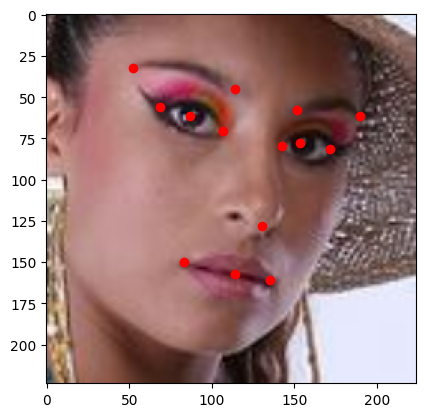

In [7]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])


ds_train = MyCustomDataset(mode="train")
ds_val = MyCustomDataset(mode="val")
dl_train = DataLoader(ds_train, batch_size=100, shuffle=True, num_workers=os.cpu_count())
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=os.cpu_count())

im = np.array(ds_train[3][0]).transpose(((1, 2, 0)))
plt.imshow(im)
print(ds_val[3][1])
plt.scatter(x = ds_train[3][1][::2], y = ds_train[3][1][1::2], c = 'red')


In [8]:
from torch import nn
class MyModel(nn.Sequential):
    def __init__(self):
        """Define computations here."""

        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, padding = 'same')
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 3, padding = 'same')
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, 3, padding = 'same')
        self.norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        self.fc1 = nn.Linear(256 * 28 * 28, 64)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(64, 28)

In [9]:
import torchmetrics


class MyTrainingModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MyModel()
        self.loss = nn.MSELoss()
        self.mse = torchmetrics.regression.MeanSquaredError()

    def training_step(self, batch, batch_idx):
        """The full training loop"""
        x, y = batch
        y_logit = self.model(x)
        loss = self.loss(y_logit, y)


        system_loss = torch.mean(((y_logit.detach() - y) / 224 * 100)**2)

        return {'loss': loss, 'train_sys' : system_loss}

    def configure_optimizers(self):
        """Define optimizers and LR schedulers."""
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=5e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.2,
            patience=5,
            verbose=True,
        )
        lr_dict = {
            # The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_loss",
        }

        return [optimizer], [lr_dict]

    def validation_step(self, batch, batch_idx):
        """The full val loop"""
        x, y = batch

        y_logit = self.model(x)
        loss = self.loss(y_logit, y)


        val_loss = torch.mean(((y_logit.detach() - y) / 224 * 100)**2)
        self.log('val_loss', val_loss, prog_bar=True)

        return {'loss': loss, 'val_loss' : val_loss}


In [110]:
!nvidia-smi|

/bin/bash: -c: line 2: syntax error: unexpected end of file


In [10]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

MyModelCheckpoint = ModelCheckpoint(dirpath='/content/drive/MyDrive/dz_face_points/runs/pl_classifier'
,
                                    filename='{epoch}-{val_loss:.3f}',
                                    monitor='val_loss',
                                    mode='min',
                                    save_top_k=1)

## Monitor a metric and stop training when it stops improving.
MyEarlyStopping = EarlyStopping(monitor = "val_loss",
                                mode = "min",
                                patience = 8,
                                verbose = True)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    callbacks=[MyModelCheckpoint],
    log_every_n_steps=5,
    num_sanity_val_steps=0,
)

training_module = MyTrainingModule()

trainer.fit(training_module, dl_train, dl_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/dz_face_points/runs/pl_classifier exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | MyModel          | 13.2 M
1 | loss  | MSELoss          | 0     
2 | mse   | MeanSquaredError | 0     
-------------------------------------------
13.2 M    Trainable params
0         Non-trainable params
13.2 M    Total params
52.875    Total estimated mo

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [12]:
model_filename = '/content/drive/MyDrive/dz_face_points/runs/pl_classifier/epoch=0-val_loss=55.582.ckpt'
model_filename2 = '/content/drive/MyDrive/dz_face_points/runs/pl_classifier/model_best_29.ckpt'

test_img_dir = '/content/drive/MyDrive/dz_face_points/tests/00_test_img_input/test/images'
model = MyTrainingModule().model
ckpt = torch.load(model_filename2, map_location='cpu')['state_dict']

ckpt = {k.replace('model.', ''):v for k,v in ckpt.items()}
model.load_state_dict(ckpt)
model.eval()
model.training = False
model.to("cpu")

ds_test = ds_val

## Init train and val dataloaders
dl_test = DataLoader(ds_test, batch_size=1, shuffle=True, num_workers=0)

ans = []

for i, (inputs, targets) in enumerate(dl_test):
    # evaluate the model on the test set
    inputs = inputs.to("cpu")
    res = model(inputs).detach()
    ans.append(res)
    print(ans)
    print(targets)
    break

#ans = torch.cat(ans, dim = 0).flatten().cpu().numpy().astype(np.float32)
im = inputs[0].permute(1,2,0)
plt.imshow(im)
plt.scatter(x = targets[0][0::2], y = targets[0][1::2], c = 'red')
plt.show()

im = inputs[0].permute(1,2,0)
plt.imshow(im)
plt.scatter(x = ans[0][0][0::2], y = ans[0][0][1::2], c = 'red')

NameError: name 'MyTrainingModule' is not defined